In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches, convert_to_one_hot, predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import os
from random import shuffle
import re
from collections import Counter

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

import urllib.request
import zipfile
import lxml.etree

from gensim.models import Word2Vec

%matplotlib inline
np.random.seed(1)

Loading BokehJS ...

In [23]:
# Download data
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = [text for text in doc.xpath("//content/text()")]
labels = [label for label in doc.xpath("//keywords/text()")]
del doc

In [24]:
def encode_label(label):
    if any(x in label for x in ["technology","entertainment","design"]):
        return "TED"
    if any(x in label for x in ["entertainment","design"]):
        return "oED"
    if any(x in label for x in ["technology","design"]):
        return "ToD"
    if any(x in label for x in ["technology","entertainment"]):
        return "TEo"
    if "technology" in label:
        return "Too"
    if "entertainment" in label:
        return "oEo"
    if "design" in label:
        return "ooD"
    
    return "ooo"

In [25]:
# Preprocess data

# Remove all parenthesized strings
texts = [re.sub(r"\([^)]*\)", "", text) for text in texts]
# Split text to array of setences
texts = [text.lower().split(".") for text in texts]
# Tokenize each sentence
texts_token = [];
for text in texts:
    token = []
    for sent in text:
        token = token + re.sub(r"[^a-z0-9]+", " ", sent).split()
    texts_token.append(token)

labels = [encode_label(label.lower()) for label in labels]

text_train = texts_token[0:1585]
label_train = labels[0:1585]

text_valid = texts_token[1585:(1585+250)]
label_valid = labels[1585:(1585+250)]

text_test = texts_token[-250:]
label_test = labels[-250:]


In [26]:
# Create embedding
model_ted = Word2Vec(texts_token, min_count=0)

In [27]:
# Encode text with embedding
def encode_text(text,model_embedding):
    X = []
    unknown_token_embed = np.zeros((1,100),dtype=np.float32)
    for token in text:
        if len(token)>0:
            X.append(np.sum(model_embedding.wv[token],axis=0)/len(token))
        if len(token)==0:
            X.append(unknown_token_embed[0])
    X = np.array(X)
    return X

X_train = encode_text(text_train,model_ted)
X_valid = encode_text(text_valid,model_ted)
X_test = encode_text(text_test,model_ted)

In [28]:
# Encode label with one hot
def encode_label_one_hot(label, C):
    
    label_enc = LabelEncoder()
    label_integer = label_enc.fit_transform(label)
    
    one_hot = np.eye(C)[label_integer.reshape(-1)]
    
    return one_hot


Y_train = encode_label_one_hot(label_train,8)
Y_valid = encode_label_one_hot(label_valid,8)
Y_test = encode_label_one_hot(label_test,8)

In [29]:
# Build graph

In [30]:
# Create placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of embedding vectors (100)
    n_y -- scalar, number of classes (from 0 to 7, so -> 8)
    
    Returns:
    X -- placeholder for the data input, of shape [None, n_x] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32,shape=[None,n_x])
    Y = tf.placeholder(tf.float32,shape=[None,n_y])
    
    return X, Y

In [31]:
# Initialize parameters
def initialize_parameters(n_x,n_h,n_y):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W : [n_x,n_h]
                        b : [1,n_h]
                        V : [n_h, n_y]
                        c : [1,n_y]
    Arguments:
    n_x -- scalar, size of embedding vectors (100)
    n_y -- scalar, number of classes (from 0 to 7, so -> 8)
    
    Returns:
    parameters -- a dictionary of tensors containing W,b,V,c
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W = tf.get_variable("W", [n_x,n_h], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b = tf.get_variable("b", [1,n_h], initializer = tf.zeros_initializer())
    V = tf.get_variable("V", [n_h,n_y], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    c = tf.get_variable("c", [1,n_y], initializer = tf.zeros_initializer())

    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}
    
    return parameters

In [37]:
# Forward propagation
def forward_propagation(X, parameters, dropout_rate):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (number of examples, input size)
    parameters -- python dictionary containing your parameters "W", "b", "V", "c"
                  the shapes are given in initialize_parameters

    Returns:
    u -- the output of the last unit, of shape (number of examples, number of classes)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W = parameters['W']
    b = parameters['b']
    V = parameters['V']
    c = parameters['c']

            
    h = tf.nn.relu(tf.add(tf.matmul(X,W),b))       # of shape (number of examples, number of hidden layers)                     
    u = tf.add(tf.matmul(h,V),c)                # of shape (number of examples, number of classes) 
    
    z = tf.nn.dropout(u,keep_prob = 1-dropout_rate)
    
    return z

In [33]:
# Compute cost
def compute_cost(Y, label):
    """
    Computes the cost
    
    Arguments:
    Y -- output of forward propagation, of shape (number of examples, number of classes)
    label -- "true" labels vector placeholder, same shape as Y
    
    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y, labels = label))
    
    return cost

In [43]:
# Build model
def model(X_train, Y_train, X_test, Y_test, hidden_size = 100, learning_rate = 0.0001, dropout_rate = 0.3,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a one-layer tensorflow neural network
    
    Arguments:
    X_train -- training set, of shape (number of training examples = 1585,input size = 100)
    Y_train -- training set, of shape (number of training examples = 1585, output size = 8)
    X_test -- test set, of shape (number of training examples = 250,input size = 100)
    Y_test -- test set, of shape (number of test examples = 250, output size = 8)
    hidden_size -- the size of the hidden layer
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (m,n_x) = X_train.shape                          # (m : number of examples in the train set, n_x: input size)
    n_y = Y_train.shape[1]                            # n_y : output size
    n_h = hidden_size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x,n_y)
   
    # Initialize parameters
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X,parameters,dropout_rate)

    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z,Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train,  mini_batch_size = minibatch_size, seed = seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.782877
Cost after epoch 100: 0.899600
Cost after epoch 200: 0.856681
Cost after epoch 300: 0.881857
Cost after epoch 400: 0.838569
Cost after epoch 500: 0.835496
Cost after epoch 600: 0.835852
Cost after epoch 700: 0.810788
Cost after epoch 800: 0.797068
Cost after epoch 900: 0.776316
Cost after epoch 1000: 0.760709
Cost after epoch 1100: 0.781141
Cost after epoch 1200: 0.746599
Cost after epoch 1300: 0.758528
Cost after epoch 1400: 0.747087


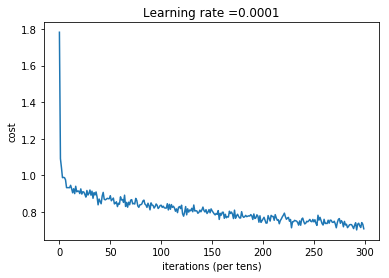

Parameters have been trained!
Train Accuracy: 0.375
Test Accuracy: 0.0


In [44]:
# Run model
parameters = model(X_train, Y_train, X_test, Y_test)

In [ ]:
# Pridict


In [251]:
permutation = list(np.random.permutation(10))

In [265]:
Y_train[permutation,:]

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])